In [2]:
import pandas as pd
import numpy as np 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
data_dict = {"Stock1": [ 41, 39, 38, 45, 41, 43, 47, 49, 41, 35, 36,39,33,28,31 ],
            "Stock2": [36, 36, 38, 51, 52, 55, 57, 58, 62, 70,72, 74,83,101,107],
            "Stock3": [35,35,32,41,39,55,52,54,65,77,75,74,81,92,91]}

df_data = pd.DataFrame(data_dict)

In [4]:
df_data

,Stock1,Stock2,Stock3
0,41,36,35
1,39,36,35
2,38,38,32
3,45,51,41
4,41,52,39
5,43,55,55
6,47,57,52
7,49,58,54
8,41,62,65
9,35,70,77


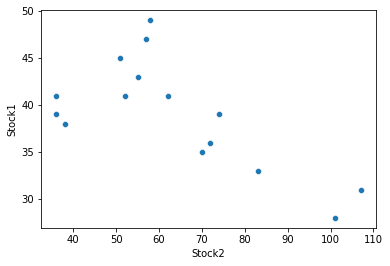

In [5]:
sns.scatterplot(data= df_data, x="Stock2", y="Stock1")

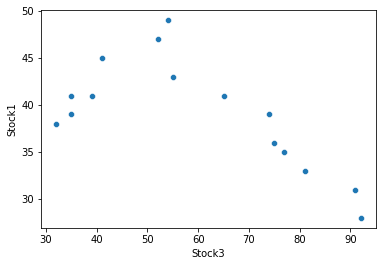

In [6]:
sns.scatterplot(data= df_data, x="Stock3", y="Stock1")

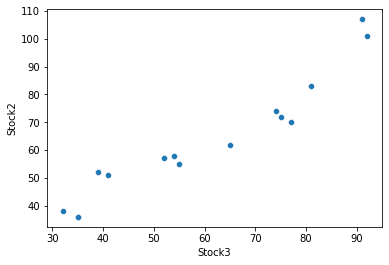

In [7]:
sns.scatterplot(data= df_data, x="Stock3", y="Stock2")

In [8]:
df_data.corr(method = "pearson")

,Stock1,Stock2,Stock3
Stock1,1.000000,-0.683155,-0.674950
Stock2,-0.683155,1.000000,0.955945
Stock3,-0.674950,0.955945,1.000000


In [9]:
df_data.corr(method = "spearman")

,Stock1,Stock2,Stock3
Stock1,1.000000,-0.595156,-0.611315
Stock2,-0.595156,1.000000,0.957066
Stock3,-0.611315,0.957066,1.000000


In [10]:
df_data.shape

(15, 3)

In [11]:
model = smf.ols(formula="Stock1 ~ Stock2 + Stock3", data=df_data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Stock1   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     5.369
Date:                Wed, 02 Mar 2022   Prob (F-statistic):             0.0216
Time:                        16:13:57   Log-Likelihood:                -42.404
No. Observations:                  15   AIC:                             90.81
Df Residuals:                      12   BIC:                             92.93
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     50.8555      3.791     13.415      0.0

In [14]:
results.ssr

28721.451702557206

In [12]:
results.resid

0    -3.094813
1    -5.094813
2    -6.069099
3     3.114758
4    -0.907766
5     2.581425
6     6.607140
7     8.867663
8     2.122045
9    -2.076812
10   -0.980336
11    2.186902
12   -2.246765
13   -4.326384
14   -0.683146
dtype: float64

In [13]:
anova_table = sm.stats.anova_lm(results, typ=2)
print(anova_table)

              sum_sq    df         F    PR(>F)
Stock2      7.933742   1.0  0.379847  0.549199
Stock3      2.641370   1.0  0.126462  0.728302
Residual  250.640268  12.0       NaN       NaN


Text(0, 0.5, 'Residuals')

Text(0.5, 0, 'Fitted Values')

Text(0.5, 1.0, 'Residuals vs. Fitted')

Text(40.13233660302613, 8.867663396973867, '7')

Text(40.392860472296576, 6.607139527703424, '6')

Text(44.06909888019653, -6.0690988801965275, '2')

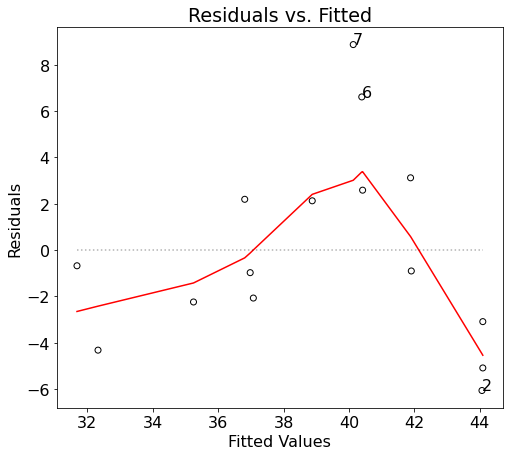

In [14]:
residuals = results.resid
fitted = results.fittedvalues
smoothed = lowess(residuals,fitted)
top3 = abs(residuals).sort_values(ascending = False)[:3]

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,7)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

for i in top3.index:
    ax.annotate(i,xy=(fitted[i],residuals[i]))

plt.show()

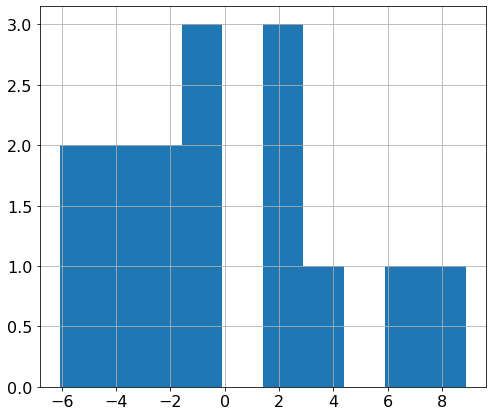

In [15]:
residuals.hist()

Text(0.5, 1.0, 'Normal Q-Q')

Text(0, 0.5, 'Standardized Residuals')

Text(0.5, 0, 'Theoretical Quantiles')

Text(-1.885410077534695, -2.252240751339366, '7')

Text(1.885410077534695, 2.0350875509459576, '20')

Text(-1.4609876467545182, -1.5218035867910058, '21')

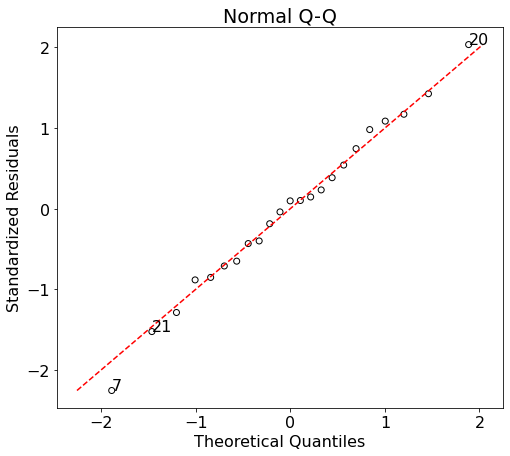

In [17]:
sorted_student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
sorted_student_residuals.index = results.resid.index
sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
df = pd.DataFrame(sorted_student_residuals)
df.columns = ['sorted_student_residuals']
df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]
rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)
top3 = rankings[:3]

fig, ax = plt.subplots()
x = df['theoretical_quantiles']
y = df['sorted_student_residuals']
ax.scatter(x,y, edgecolor = 'k',facecolor = 'none')
ax.set_title('Normal Q-Q')
ax.set_ylabel('Standardized Residuals')
ax.set_xlabel('Theoretical Quantiles')
ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
for val in top3.index:
    ax.annotate(val,xy=(df['theoretical_quantiles'].loc[val],df['sorted_student_residuals'].loc[val]))
plt.show()

In [17]:
df_data['Interaction_2_3'] = df_data['Stock2']*df_data['Stock3']
df_data

,Stock1,Stock2,Stock3,Interaction_2_3
0,41,36,35,1260
1,39,36,35,1260
2,38,38,32,1216
3,45,51,41,2091
4,41,52,39,2028
5,43,55,55,3025
6,47,57,52,2964
7,49,58,54,3132
8,41,62,65,4030
9,35,70,77,5390


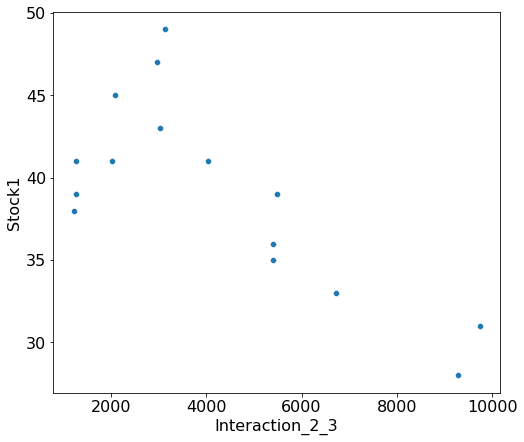

In [18]:
sns.scatterplot(data= df_data, x="Interaction_2_3", y="Stock1")

In [19]:
df_data.corr(method = "pearson")

,Stock1,Stock2,Stock3,Interaction_2_3
Stock1,1.000000,-0.683155,-0.674950,-0.751510
Stock2,-0.683155,1.000000,0.955945,0.990461
Stock3,-0.674950,0.955945,1.000000,0.965850
Interaction_2_3,-0.751510,0.990461,0.965850,1.000000


# Earlier model with Manufacturing Reps had a R square of 0.47 and Adj R square 0.38

In [20]:
model = smf.ols(formula="Stock1 ~ Stock1 + Stock2 + Interaction_2_3", data=df_data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Stock1   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.669e+26
Date:                Wed, 02 Mar 2022   Prob (F-statistic):          1.05e-144
Time:                        16:17:08   Log-Likelihood:                 406.29
No. Observations:                  15   AIC:                            -804.6
Df Residuals:                      11   BIC:                            -801.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -9.521e-13   1.62e-12     